Source: This example comes from the torch adaptation of Charles Ollion [/github/charlesollion].

In [427]:

import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

Data Acquisition

In [428]:
df = pd.read_csv("preprocessed_dataset.csv")
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

Data loading and preprocessing. Data is similar to project work, and has

In [429]:
attributes = list(df.columns)
data = df.values

Function for splitting the dataset into sequences of observations of length history size.

In [430]:
def sequencing(dataset, start_index=0, end_index=None, history_size=31, step=1):
    data = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
    return np.array(data)


Function for splitting the dataset into training and validation, and data normalization.

In [431]:
def partition(data, pTrain=0.8, pVal = 0.5, save_path=None):
    # I don't like this normalization before training thingie
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    data = (data - data_mean)/data_std
    stats = (data_mean, data_std)

    sequencedData = sequencing(data, start_index=0, end_index=None, history_size=31, step=1)
    # plt.plot(sequencedData[:, 0, 0])
    # plt.show()

    dataTrain = sequencedData[:int(sequencedData.shape[0]*0.8), :, :]
    dataVal = sequencedData[int(sequencedData.shape[0]*0.8):int(sequencedData.shape[0]*0.9), :, :]
    dataTest = sequencedData[int(sequencedData.shape[0]*0.9):, :, :]

    return dataTrain, dataVal, dataTest

Create input-putput pairs.

In [432]:
def split(chunk):
    inputs = torch.tensor(chunk[:, :-1, :], device=device) # What about that device?
    targets = torch.tensor(chunk[:, 1:, :], device=device)
    return inputs, targets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loaders

In [433]:
def createLoaders(dataTrain, dataVal, dataTest, batchSize=32, responseVariables=[0, 1, 2, 3]):
    XTrain, YTrain = split(dataTrain)
    XVal, YVal = split(dataVal)
    XTest, YTest = split(dataTest)

    YTrain = torch.unsqueeze(YTrain[:,:,responseVariables], 2) if len(responseVariables) == 1 else YTrain[:,:,responseVariables]
    YVal = torch.unsqueeze(YVal[:,:,responseVariables], 2) if len(responseVariables) == 1 else YVal[:,:,responseVariables]
    YTest = torch.unsqueeze(YTest[:,:,responseVariables], 2) if len(responseVariables) == 1 else YTest[:,:,responseVariables]
    
    # XTrain = torch.cat([XTrain[:, :, :responseVariables], XTrain[:, :, responseVariables+1:]], dim=2)
    # XVal = torch.cat([XVal[:, :, :responseVariables], XVal[:, :, responseVariables+1:]], dim=2)
    # XTest = torch.cat([XTest[:, :, :responseVariables], XTest[:, :, responseVariables+1:]], dim=2)
    
    trainDS = torch.utils.data.TensorDataset(XTrain, YTrain)
    valDS = torch.utils.data.TensorDataset(XVal, YVal)
    testDS = torch.utils.data.TensorDataset(XTest, YTest)

    trainLoader = torch.utils.data.DataLoader(trainDS, batch_size=batchSize)
    valLoader = torch.utils.data.DataLoader(valDS, batch_size=batchSize)
    testLoader = torch.utils.data.DataLoader(testDS, batch_size=batchSize)

    return trainLoader, valLoader, testLoader

trainData, valData, testData = partition(data)
trainDataset, valDataset, testDataset = createLoaders(trainData, valData, testData)

(inputs, targets) = next(iter(trainDataset))
print(inputs.shape)
print(targets.shape)
                         

torch.Size([32, 30, 4])
torch.Size([32, 30, 4])


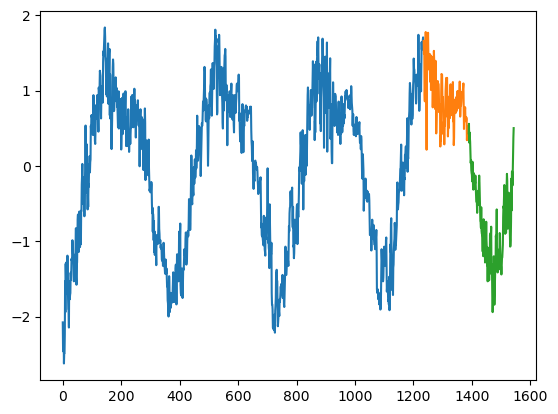

In [434]:
# %matplotlib qt
%matplotlib inline
plt.plot(np.array(list(range(trainData[:, 0, 0].shape[0]))), trainData[:, 0, 0])
plt.plot(np.array(list(range(trainData[:, 0, 0].shape[0], 
                             trainData[:, 0, 0].shape[0] + valData[:, 0, 0].shape[0]))), valData[:, 0, 0])
plt.plot(np.array(list(range(trainData[:, 0, 0].shape[0] + valData[:, 0, 0].shape[0], 
                             trainData[:, 0, 0].shape[0] + valData[:, 0, 0].shape[0] + testData[:, 0, 0].shape[0]))), testData[:, 0, 0])
plt.show()

Transformer NN implementation

In [435]:
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension
        
        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)
        
        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

In [436]:
B, S, H, D = 9, 11, 5, 8
mha = MultiHeadAttention(D, H)
out, att = mha.forward(torch.zeros(B, S, D), mask=None)
out.shape, att.shape

(torch.Size([9, 11, 8]), torch.Size([9, 5, 11, 11]))

In [437]:
# Positional encodings
def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates


def positional_encoding(D, position=30, dim=3, device=device):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(D)[np.newaxis, :],
                            D)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
    return torch.tensor(pos_encoding, device=device)

# function that implement the look_ahead mask for masking future time steps. 
def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1).double()
    return mask  # (size, size)

create_look_ahead_mask(6)

class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)


    def forward(self, x, look_ahead_mask):
        
        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)
        
        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights

In [438]:
dl = TransformerLayer(16, 3, 32, 0.1)
out, attn = dl(x=torch.zeros(5, 7, 16), look_ahead_mask=None)
out.shape, attn.shape

(torch.Size([5, 7, 16]), torch.Size([5, 3, 7, 7]))

In [439]:
class Transformer(nn.Module):
    '''Transformer Decoder Implementating several Decoder Layers.
    '''
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.sqrt_D = torch.tensor(math.sqrt(D))
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim, 
                                        dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)
        self.double()

    def forward(self, x, mask):
        B, S, D = x.shape
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D
        
        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block
        
        x = self.output_projection(x)
        
        return x, attention_weights # (B,S,S)

In [440]:
# Test Forward pass on the Transformer: 
transformer = Transformer(num_layers=1, D=32, H=1, hidden_mlp_dim=32,
                                       inp_features=4, out_features=4, dropout_rate=0.1)
transformer.to(device)
(inputs, targets) = next(iter(trainDataset))
print(inputs.shape)
print(targets.shape)
                         
S = inputs.shape[1]
mask = create_look_ahead_mask(S)
out, attn = transformer (x=inputs, mask=mask)
out.shape, attn["decoder_layer1"].shape

torch.Size([32, 30, 4])
torch.Size([32, 30, 4])


(torch.Size([32, 30, 4]), torch.Size([32, 1, 30, 30]))

Training the Transformer

In [441]:
param_sizes = [p.numel() for p in transformer.parameters()]
print(f"number of weight/biases matrices: {len(param_sizes)} "
      f"for a total of {np.sum(param_sizes)} parameters ")

number of weight/biases matrices: 20 for a total of 6756 parameters 


In [464]:
#########################################################
#TODO
# num_layers = number of the whole TransformerLayer
# D = attention heads dimension?
# H = number of attention heads
# hidden_mlp_dim = linear/FC layer dimension
# inp_features = input features (how many variables we input)
# out_features = output features (how many variables we want to predict)
# dropout_rate = dropout rate :D
transformer = Transformer(num_layers=4, D=32, H=64, hidden_mlp_dim=32,
                          inp_features=4, out_features=4, dropout_rate=0.1).to(device)

optimizer = torch.optim.RMSprop(transformer.parameters(), 
                                lr=0.00005)

In [470]:
!pip3 install tqdm
from tqdm import tqdm

n_epochs = 100
niter = len(trainDataset)
losses, val_losses = [], []

for e in tqdm(range(n_epochs)):
    
    # one epoch on train set
    transformer.train()
    sum_train_loss = 0.0
    for x,y in trainDataset:
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(sum_train_loss / niter)
    
    # Evaluate on val set
    transformer.eval()
    sum_val_loss = 0.0
    for i, (x, y) in enumerate(valDataset):
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_val_loss += loss.item()
    val_losses.append(sum_val_loss / (i + 1))

100%|██████████| 100/100 [05:21<00:00,  3.21s/it]


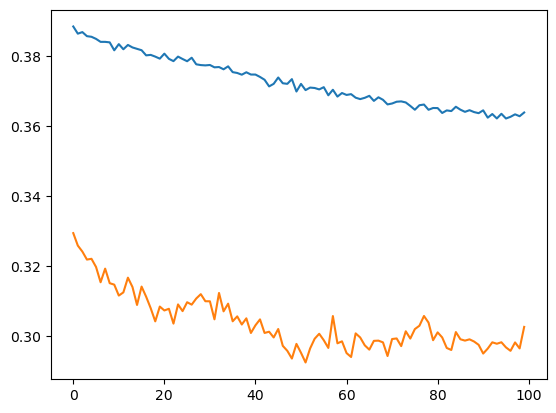

In [471]:
plt.plot(losses)
plt.plot(val_losses)

In [472]:
# Here we just de-sequence the sequenced validation data
valTarget = [target[0, :] for target in valData]
valTarget = np.array(valTarget)
valTarget

array([[ 1.65895572e+00, -9.56899474e-01,  3.34938266e-01,
        -1.56868594e+00],
       [ 1.48626737e+00, -8.86105933e-01,  8.80710933e-01,
        -1.70375943e+00],
       [ 1.57715598e+00, -9.21502704e-01, -7.77191169e-02,
        -1.63172024e+00],
       [ 9.51972231e-01, -7.36933829e-01,  1.78515534e+00,
        -1.21234919e+00],
       [ 8.58179293e-01, -4.06697041e-01,  3.52998351e-01,
        -1.05493271e+00],
       [ 1.08872853e+00, -8.14799396e-01,  7.22644571e-01,
        -1.49508067e+00],
       [ 1.36846176e+00, -9.34663042e-01,  1.83550022e+00,
        -1.26875351e+00],
       [ 1.77793716e+00, -2.02523837e+00,  1.86683972e+00,
        -1.16060025e+00],
       [ 1.47661046e+00, -1.36691207e+00,  1.66436555e+00,
        -1.17697280e+00],
       [ 8.54591585e-01, -1.98081207e-01,  1.05995436e+00,
        -9.85618677e-01],
       [ 2.15531095e-01,  8.49073255e-01,  5.73251602e-01,
        -6.39492842e-01],
       [ 1.01040062e+00, -5.43094371e-01,  1.11706046e-01,
      

In [473]:
transformer.eval()

# Here I get the first sequence from the validation dataset - so first 30 days from val data to predict from
(inputs, targets) = next(iter(valDataset))
last_x = torch.unsqueeze(inputs[0], 0)  # unsqueeze because of the NN wants it this way, from [[1...5]..[1...5]] to [[[1...5]..[1...5]]]
# Adding the first 30 days to the prediction list that will have the predictions
validation_predictions = list(last_x[0].detach().cpu().numpy())

# While we do not have enough days predicted, we continue
while len(validation_predictions) < len(valTarget):
    S = last_x.shape[1]
    mask = create_look_ahead_mask(S)
    # Predict
    p, attn = transformer(x=last_x, mask=mask)
    # Add the new predicted values for one day to the prediction list
    validation_predictions.append(p[0, -1, :].detach().cpu().numpy())
    # Roll to predict new day in next iteration
    last_x = torch.roll(last_x, -1, dims=0)
    last_x[-1] = p[0, -1, :]

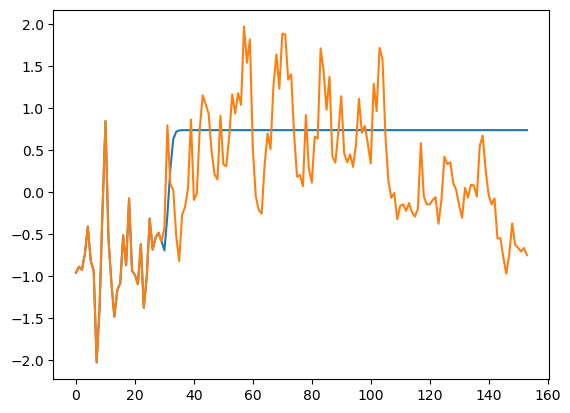

In [474]:
# %matplotlib qt
%matplotlib inline
plt.plot(np.array(validation_predictions)[:, 1])
plt.plot(valTarget[:, 1])
plt.show()